## 1) Setup

In [ ]:

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, Ridge, LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error

np.set_printoptions(suppress=True, linewidth=140)
pd.set_option("display.width", 200)
pd.set_option("display.max_columns", 120)

RANDOM_SEED = 1337 #fixed seed for deterministic splits
N_SPLITS = 5 #using a 5-fold cross validation
USE_PCA = False


## 2) Paths and file upload

In [ ]:
DATA_DIR = "/content"
PATH_RNA = f"{DATA_DIR}/HEK293T_RNA_CLR_wide.csv"
PATH_TE  = f"{DATA_DIR}/HEK293T_TE_CLR_wide.csv"
PATH_TX2GENE = f"{DATA_DIR}/tx2gene.csv"

OUT_DIR = os.path.join(DATA_DIR, "week3_outputs")
os.makedirs(OUT_DIR, exist_ok=True)

print("Data dir:", DATA_DIR)
print("Outputs →", OUT_DIR)

try:
    from google.colab import files
    print("Upload RNA and TE CSVs")
    # upload files directly
    uploaded = files.upload()
    print("Uploaded:", list(uploaded.keys()))
except ImportError:
    print("An error occurred during file upload:")
except Exception as e:
    print(f"An error occurred during file upload: {e}")

Data dir: /content
Outputs → /content/week3_outputs
Upload RNA and TE CSVs


Saving RNA_HEK293T.csv to RNA_HEK293T.csv
Saving TE_HEK293T.csv to TE_HEK293T.csv
Uploaded: ['RNA_HEK293T.csv', 'TE_HEK293T.csv']


## 3) Helper functions for cleaning

In [ ]:
def drop_index_like(df: pd.DataFrame) -> pd.DataFrame:
    return df.drop(columns=["Unnamed: 0"], errors="ignore")

def pick_id_col(cols) -> str:
    for c in ["gene", "transcript", "feature_id", "id"]:
        if c in cols: return c
    return cols[0]

def safe_pearsonr(a: np.ndarray, b: np.ndarray) -> float:
    if np.std(a) == 0 or np.std(b) == 0:
        return float("nan")
    r = np.corrcoef(a, b)[0,1]
    return float(r) if np.isfinite(r) else float("nan")

def eval_per_gene(y_true: np.ndarray, y_pred: np.ndarray, ids) -> pd.DataFrame:
    rows = []
    for j, gid in enumerate(ids):
        yt = y_true[:, j]; yp = y_pred[:, j]
        r  = safe_pearsonr(yt, yp)
        ss_res = np.sum((yt - yp)**2)
        ss_tot = np.sum((yt - np.mean(yt))**2)
        r2 = float("nan") if ss_tot == 0 else 1.0 - (ss_res/ss_tot)
        mae = mean_absolute_error(yt, yp)
        rmse = mean_squared_error(yt, yp)
        rows.append({"id": gid, "pearson_r": r, "r2": r2, "mae": mae, "rmse": rmse})
    return pd.DataFrame(rows)

def to_gene_symbols(df: pd.DataFrame, id_col: str, tx2gene: pd.DataFrame=None) -> pd.DataFrame:
    if tx2gene is None or not set(["transcript","gene_symbol"]).issubset(tx2gene.columns):
        out = df.copy(); out["gene_symbol"] = out[id_col].astype(str); return out
    if id_col.lower() != "transcript":
        out = df.copy(); out["gene_symbol"] = out[id_col].astype(str); return out
    out = df.merge(tx2gene[["transcript","gene_symbol"]], left_on=id_col, right_on="transcript", how="left")
    out["gene_symbol"] = out["gene_symbol"].fillna(out[id_col].astype(str))
    out = out.drop(columns=["transcript_y"], errors="ignore")
    out = out.rename(columns={"transcript_x":"transcript"})
    return out

def rps_rpl_mask(symbols: pd.Series) -> pd.Series:
    s = symbols.fillna("").str.upper()
    return s.str.startswith("RPS") | s.str.startswith("RPL")

## 4) Load and align RNA/TE matrices

In [ ]:
rna = drop_index_like(pd.read_csv(f"{DATA_DIR}/RNA_HEK293T.csv"))
te  = drop_index_like(pd.read_csv(f"{DATA_DIR}/TE_HEK293T.csv"))

id_col_rna = pick_id_col(rna.columns.tolist())
id_col_te  = pick_id_col(te.columns.tolist())

sample_cols = [c for c in rna.columns if c != id_col_rna and c in te.columns]
rna = rna[[id_col_rna] + sample_cols].copy()
te  = te [[id_col_te ] + sample_cols].copy()

common_ids = sorted(set(rna[id_col_rna]) & set(te[id_col_te]))
rna = rna[rna[id_col_rna].isin(common_ids)].sort_values(id_col_rna).reset_index(drop=True)
te  = te [te [id_col_te ].isin(common_ids)].sort_values(id_col_te ).reset_index(drop=True)

rna = rna.rename(columns={id_col_rna: "feature_id"})
te  = te .rename(columns={id_col_te:  "feature_id"})

print("RNA shape:", rna.shape)
print("TE  shape:", te.shape)
print("Samples:", len(sample_cols))

RNA shape: (8433, 99)
TE  shape: (8433, 99)
Samples: 98


## 5) Add gene symbols and build ML matrices

In [ ]:

import pandas as pd, os

tx2gene = None
if os.path.exists(PATH_TX2GENE):
    try:
        tx2gene = pd.read_csv(PATH_TX2GENE)
    except Exception as e:
        print("Warning: could not read tx2gene.csv:", e)

rna_sym = to_gene_symbols(rna, "feature_id", tx2gene)
te_sym  = to_gene_symbols(te,  "feature_id", tx2gene)

genes = rna["feature_id"].tolist()
gene_symbols = rna_sym["gene_symbol"].tolist()

X = rna[sample_cols].T.values  # RNA
Y = te [sample_cols].T.values  # TE

print("Matrix shapes — X:", X.shape, "Y:", Y.shape)


Matrix shapes — X: (98, 8433) Y: (98, 8433)


Lasso

In [ ]:
from sklearn.decomposition import PCA

# Masks to identity ribosomal clusters, converting to uppercase
sym = pd.Series(gene_symbols).str.upper()
mask_rps = sym.str.startswith("RPS")
mask_rpl = sym.str.startswith("RPL")

#ensure not null/they exist
assert mask_rps.any() and mask_rpl.any(), "No RPS/RPL genes detected in gene_symbols."

# make a single target per cluster from per-gene TE (Y)
def cluster_signal(Y_block, method="mean", n_components=1, random_state=1337):
    """
    Y_block: samples × k_genes slice from Y
    method : 'mean' or 'pca'
    returns: vector length = samples
    """
    #simple avg across all genes in cluster
    if method == "mean":
        return np.nanmean(Y_block, axis=1)
    #shows variation pattern
    elif method == "pca":
        # Center per gene; take PC1 score
        Yc = Y_block - np.nanmean(Y_block, axis=0, keepdims=True)
        pcs = min(n_components, min(*Yc.shape))
        s = PCA(n_components=pcs, random_state=random_state).fit_transform(Yc)[:, 0]
        return s
    else:
        raise ValueError("method must be 'mean' or 'pca'.")

# Build cluster targets, 1 target vector per cluster (mean for baseline)
TE_RPS = cluster_signal(Y[:, mask_rps.values], method="mean")
TE_RPL = cluster_signal(Y[:, mask_rpl.values], method="mean")

print("Cluster targets shapes:", TE_RPS.shape, TE_RPL.shape)


Cluster targets shapes: (98,) (98,)


In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

def cv_predict_vector(X, y, alphas=None, n_splits=5, random_state=1337):
    """
    Cross-validated predictions for a single target vector y using LassoCV.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    yhat = np.zeros_like(y, dtype=float) #predictions aligned to each y, each point redicted out of fold
    chosen_alphas, nnz_coefs = [], [] #number of nonzero coefficients, for sparsity and alpha chosen by lasso cv in outer folds

    for tr_idx, te_idx in kf.split(X):
        Xtr, Xte = X[tr_idx], X[te_idx]
        ytr = y[tr_idx]

        # Scale features inside each fold
        scaler = StandardScaler().fit(Xtr)
        Xtr_s = scaler.transform(Xtr)
        Xte_s = scaler.transform(Xte)

        # LassoCV over a reasonable grid if no alpha (log values)
        if alphas is None:
            alphas = np.logspace(-3, 1, 20)  #ex: 0.001 becomes 10
            # internal cv (train split)
        lcv = LassoCV(alphas=alphas, cv=5, random_state=random_state, n_jobs=-1, max_iter=10000)
        lcv.fit(Xtr_s, ytr)

        #predict test split
        yhat[te_idx] = lcv.predict(Xte_s)
        chosen_alphas.append(lcv.alpha_)
        nnz_coefs.append(int(np.sum(np.abs(lcv.coef_) > 1e-8)))

    return yhat, np.array(chosen_alphas), np.array(nnz_coefs)

# Run for both clusters
Yhat_RPS, alphas_rps, nnz_rps = cv_predict_vector(X, TE_RPS)
Yhat_RPL, alphas_rpl, nnz_rpl = cv_predict_vector(X, TE_RPL)

def summarize_cluster(y_true, y_pred, name):
    r = np.corrcoef(y_true, y_pred)[0,1] if (np.std(y_true)>0 and np.std(y_pred)>0) else np.nan
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    print(f"{name}: r={r:.3f}, MAE={mae:.3f}, RMSE={rmse:.3f}")

summarize_cluster(TE_RPS, Yhat_RPS, "RPS cluster")
summarize_cluster(TE_RPL, Yhat_RPL, "RPL cluster")

print("Median alpha (RPS, RPL):", np.median(alphas_rps), np.median(alphas_rpl))
print("Median non-zero features (RPS, RPL):", int(np.median(nnz_rps)), int(np.median(nnz_rpl)))

RPS cluster: r=0.938, MAE=0.182, RMSE=0.096
RPL cluster: r=0.950, MAE=0.212, RMSE=0.111
Median alpha (RPS, RPL): 0.011288378916846888 0.018329807108324356
Median non-zero features (RPS, RPL): 41 45


In [ ]:
#Lasso model on full data using median alpha across cv folds
def fit_full_lasso(X, y, alpha):
    scaler = StandardScaler().fit(X)
    Xs = scaler.transform(X)
    model = LassoCV(alphas=[alpha], cv=5, random_state=RANDOM_SEED, max_iter=10000).fit(Xs, y)
    return model, scaler

alpha_rps = float(np.median(alphas_rps))
alpha_rpl = float(np.median(alphas_rpl))

lasso_rps, scaler_rps = fit_full_lasso(X, TE_RPS, alpha_rps)
lasso_rpl, scaler_rpl = fit_full_lasso(X, TE_RPL, alpha_rpl)

# Top features by absolute val weight
def top_features(model, k=20):
    w = model.coef_
    idx = np.argsort(-np.abs(w))[:k]
    return pd.DataFrame({
        "gene_id": [genes[i] for i in idx],
        "gene_symbol": [gene_symbols[i] for i in idx],
        "weight": w[idx]
    })

print("\nTop RNA features for RPS cluster:\n", top_features(lasso_rps).to_string(index=False))
print("\nTop RNA features for RPL cluster:\n", top_features(lasso_rpl).to_string(index=False))




Top RNA features for RPS cluster:
 gene_id gene_symbol    weight
  RPL10       RPL10 -0.264835
 EEF1A1      EEF1A1 -0.198144
ATP5MC2     ATP5MC2 -0.086245
  ZNF41       ZNF41  0.050961
 RPL27A      RPL27A -0.049612
  PMPCB       PMPCB -0.046176
  SHLD2       SHLD2  0.043527
  RAB2B       RAB2B  0.034850
  COQ8A       COQ8A -0.034244
    KHK         KHK  0.030256
 CAMKMT      CAMKMT  0.027970
  MBTD1       MBTD1  0.026960
   KDSR        KDSR  0.025211
SLC10A7     SLC10A7  0.023569
TMEM101     TMEM101 -0.022951
  RAB8A       RAB8A  0.021609
  FANCI       FANCI -0.019094
  VPS18       VPS18  0.018570
  PPTC7       PPTC7  0.018034
   ASB8        ASB8  0.017605

Top RNA features for RPL cluster:
 gene_id gene_symbol    weight
 RPL13A      RPL13A -0.381985
 RPL27A      RPL27A -0.141922
ATP5MC2     ATP5MC2 -0.106664
  ARL4D       ARL4D  0.071559
  PMPCB       PMPCB -0.051066
  MBTD1       MBTD1  0.049421
  SHLD2       SHLD2  0.035416
  NDEL1       NDEL1  0.035248
   NCK2        NCK2  0.03441

#Interestingly, several RPL genes appear with negative weights in the RPS model and vice versa, suggesting anti-correlation in translational responses

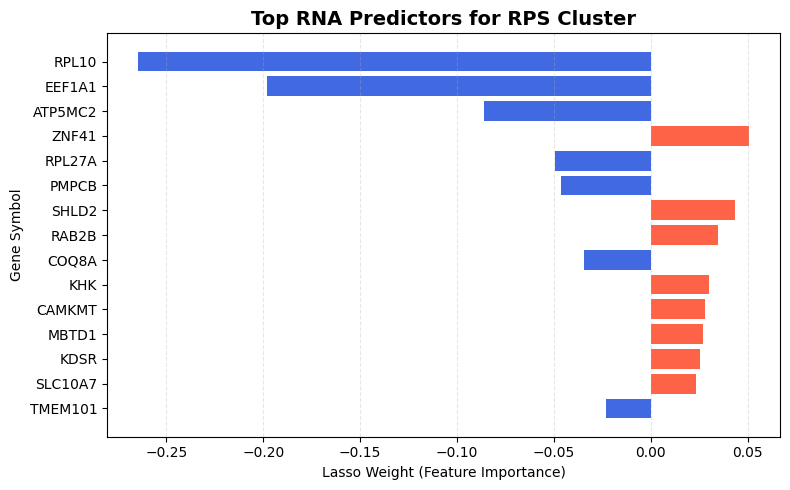

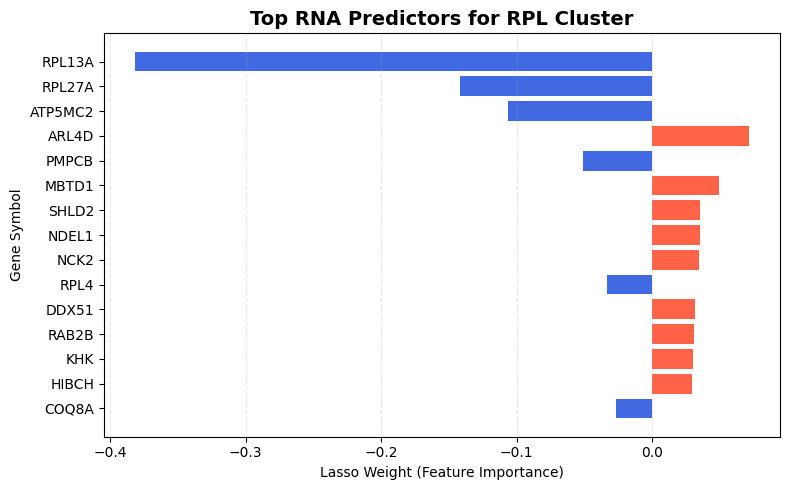

In [ ]:
def plot_lasso_weights(df, title, top_k=15):
    """
    Create a horizontal barplot of the top_k most important RNA features.
    Red = positive weight (higher RNA, higher cluster TE)
    Blue = negative weight (higher RNA, lower cluster TE)
    """
    # Sort by absolute weight, take top_k
    df_sorted = df.reindex(df["weight"].abs().sort_values(ascending=False).index)[:top_k]

    plt.figure(figsize=(8, 5))
    colors = df_sorted["weight"].apply(lambda x: "tomato" if x > 0 else "royalblue")

    plt.barh(df_sorted["gene_symbol"], df_sorted["weight"], color=colors)
    plt.gca().invert_yaxis()  # most important feature on top

    plt.title(title, fontsize=14, weight="bold")
    plt.xlabel("Lasso Weight (Feature Importance)")
    plt.ylabel("Gene Symbol")
    plt.grid(alpha=0.3, linestyle="--", axis="x")
    plt.tight_layout()
    plt.show()

top_rps_df = top_features(lasso_rps, k=20)
top_rpl_df = top_features(lasso_rpl, k=20)

plot_lasso_weights(top_rps_df, "Top RNA Predictors for RPS Cluster", top_k=15)
plot_lasso_weights(top_rpl_df, "Top RNA Predictors for RPL Cluster", top_k=15)

In [ ]:
import numpy as np, pandas as pd
from sklearn.linear_model import Lasso
from joblib import Parallel, delayed

# Prepare standardized TE
# Read the TE data again to ensure a clean start for this cell
te = drop_index_like(pd.read_csv(f"{DATA_DIR}/TE_HEK293T.csv"))

# Select only the sample columns and convert to numeric, coercing errors
sample_cols = [c for c in te.columns if c != "feature_id"]
Y = te[sample_cols].apply(pd.to_numeric, errors="coerce").values

# Add print statements to check for NaNs
print(f"Number of NaNs in Y before imputation: {np.isnan(Y).sum()}")

# Identify and remove columns with all NaNs
all_nan_cols_mask = np.all(np.isnan(Y), axis=0)
Y = Y[:, ~all_nan_cols_mask]
# Update gene names accordingly
gene_names = [gene_names[i] for i, is_all_nan in enumerate(all_nan_cols_mask) if not is_all_nan]

print(f"Number of columns removed due to all NaNs: {np.sum(all_nan_cols_mask)}")
print(f"Shape of Y after removing all NaN columns: {Y.shape}")


# Impute remaining NaNs with the mean of each column
Y = np.nan_to_num(Y, nan=np.nanmean(Y, axis=0))

# Check for NaNs after imputation
print(f"Number of NaNs in Y after imputation: {np.isnan(Y).sum()}")


# Standardize the data
Y = (Y - Y.mean(0, keepdims=True)) / (Y.std(0, ddof=1, keepdims=True) + 1e-8)

G = Y.shape[1]
alpha = 0.01  # tune a bit

def fit_neighborhood(j):
    X = np.delete(Y, j, axis=1)
    y = Y[:, j]
    # Ensure y does not contain NaNs before fitting
    if np.isnan(y).any():
        # This case should ideally not be reached after imputation, but as a safeguard:
        raise ValueError(f"NaN values found in target variable y for gene index {j}")

    m = Lasso(alpha=alpha, max_iter=5000).fit(X, y)
    coef = m.coef_
    # Insert zero back at position j
    full = np.insert(coef, j, 0.0)
    return full

# Use the columns of the TE data as gene names for the output

W = Parallel(n_jobs=-1, verbose=0)(delayed(fit_neighborhood)(j) for j in range(G))
W = np.vstack(W)                       # W[j, i] = weight of gene i predicting gene j
A = ((np.abs(W) + np.abs(W.T)) > 1e-6).astype(float)  # symmetrize (OR rule)
np.fill_diagonal(A, 0.0)

pd.DataFrame(A, index=gene_names, columns=gene_names).to_csv("adjacency_neighborhood.csv")
print("Neighborhood graph saved. Edges:", int(A.sum()))

Number of NaNs in Y before imputation: 8433
Number of columns removed due to all NaNs: 1
Shape of Y after removing all NaN columns: (8433, 98)
Number of NaNs in Y after imputation: 0
Neighborhood graph saved. Edges: 2658
